# Proyecto Magdalena

## Reconocimiento de líneas de surco y espacios vacíos


En el siguiente jupyter notebook encontrarán el flujo de procesamiento de las imágenes que desarrollamos a lo largo de las últimas semanas. 

Integrantes: 

- Elda Magally Calderon Motta 16003182
- Lilian Rebeca Carrera Lemus 20008077
- Jose Alejandro Benavides Rodriguez 20044075
- Juan Pablo Carranza Hurtado 20000607
- José Sebastián Rodríguez Velásquez 20003076
- Diego Fernando Valle Morales 20003022
- Edwin Estuardo Zapeta Gomez 05244028


### Introducción

Con el objetivo de lograr una producción eficiente de caña de azúcar, se ve la necesidad  de cambios en las prácticas agrícolas tradicionales. En consecuencia, la búsqueda de tecnologías apropiadas para el aumento del rendimiento agrícola ha sido una preocupación de los productores.

Los entornos agrícolas se ven afectados por discontinuidades (vacíos) que pueden estar presentes en los surcos de cultivo, esto en consecuencia genera defectos en la siembra, plagas o enfermedades. La alta densidad de maleza, otro factor determinante también, suele producir una impresión falsa de filas de cultivo. Líneas curvas de cultivo, terrenos con pendiente o marcas de tractor también pueden añadir cierto grado de dificultad.

Estos enfoques han conducido a contribuir en un esfuerzo por identificar espacios vacíos y líneas de surco utilizando como referencia el concepto de visión artificial. 

Los sistemas de visión por computadora aplicados a las actividades agrícolas tienen un gran potencial, logrando que se reduzcan tareas manuales, el costo en el proceso productivo y evidentemente generando un ventaja competitiva en los ingenios. La necesidad de crear mecanismos capaces de identificar características visuales en el campo de cultivo y tomar decisiones a partir de la información generada lleva al crecimiento de nuevos campos de investigación como la agricultura de precisión y guiado automático de tractores en tiempo real.


### Objetivos:

#### General:

- Determinar líneas de surco y extraer espacios vacíos.

#### Específicos:

- Revisar referencias bibliográficas para la selecciónd e métodos de visión por computadora para la detección de líoneas de cultivo y espacios vacíos.
- Desarrollar algoritmos de visión por computadora para la detección automática de líenas de surco y extracción de espacios vacíos.
- Evaluar los resultados alcanzados haciendo comparativas con herramientas comerciales

### Metodología

Para la resolución del problema de reconocimiento de líneas de surco y espacios vacíos se dividió el problema en dos principales partes:

- Reconocimiento de las líneas de surco por medio de una transformada de Hough normalizada

- Reconocimiento de los espacios vacíos por medio de heurísticas basadas en el color de la caña vs. el color de los espacios vacíos

### Detección de líneas de surco:

- Primero se realiza una transformación de la imagen a un espacio de color llamado ExG.

- Posteriormente se hace un reconocimiento del ángulo de las imágenes por medio de la utilización de filtros de Sobel verticales y horizontales. Se utilizan los valores encontrados por estos filtros en cada uno de los pixeles de la imagen para calcular con ellos un ***arc tan***, que posteriormente se realiza un promedio de los 8 pixeles circundantes a cada pixel para generar un arreglo de todos los ángulos encontrados. Se genera una distribución de probabilidad con ellos para encontrar cuál es el valor de ángulo que más se repite en la imagen.

- Se utiliza un thresholding the Otsu para generar la imagen binarizada.

- Con el resultante de la binarización se realiza una esquelitización de la imagen para generar líneas de 1 pixel de grosor.

- Esta imagen es enviada al algoritmo de reconocimiento de líneas utilizando una transformación de Hough normalizada

In [180]:
import PIL
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.color import rgb2gray
from skimage.util import invert
from skimage.transform import hough_line
import image_slicer
from skimage.transform import hough_line_peaks, rotate
from skimage.filters import sobel_h, sobel_v, gaussian
import random

In [ ]:
# Se suprime una warning que previene que se descompriman imagenes de gran tamaño
PIL.warnings.simplefilter('ignore', PIL.Image.DecompressionBombWarning)

In [ ]:
# Se carga la imagen
img = cv2.imread('imagenes/Tmpisque.tif')
cv2.imwrite('Tmpisque.png',img) # se transforma imagen a png

In [3]:
image_slicer.slice('Tmpisque.png',64)

(<Tile #1 - Tmpisque_01_01.png>,
 <Tile #2 - Tmpisque_01_02.png>,
 <Tile #3 - Tmpisque_01_03.png>,
 <Tile #4 - Tmpisque_01_04.png>,
 <Tile #5 - Tmpisque_01_05.png>,
 <Tile #6 - Tmpisque_01_06.png>,
 <Tile #7 - Tmpisque_01_07.png>,
 <Tile #8 - Tmpisque_01_08.png>,
 <Tile #9 - Tmpisque_02_01.png>,
 <Tile #10 - Tmpisque_02_02.png>,
 <Tile #11 - Tmpisque_02_03.png>,
 <Tile #12 - Tmpisque_02_04.png>,
 <Tile #13 - Tmpisque_02_05.png>,
 <Tile #14 - Tmpisque_02_06.png>,
 <Tile #15 - Tmpisque_02_07.png>,
 <Tile #16 - Tmpisque_02_08.png>,
 <Tile #17 - Tmpisque_03_01.png>,
 <Tile #18 - Tmpisque_03_02.png>,
 <Tile #19 - Tmpisque_03_03.png>,
 <Tile #20 - Tmpisque_03_04.png>,
 <Tile #21 - Tmpisque_03_05.png>,
 <Tile #22 - Tmpisque_03_06.png>,
 <Tile #23 - Tmpisque_03_07.png>,
 <Tile #24 - Tmpisque_03_08.png>,
 <Tile #25 - Tmpisque_04_01.png>,
 <Tile #26 - Tmpisque_04_02.png>,
 <Tile #27 - Tmpisque_04_03.png>,
 <Tile #28 - Tmpisque_04_04.png>,
 <Tile #29 - Tmpisque_04_05.png>,
 <Tile #30 - Tmpisque_0

In [191]:
img = cv2.imread("Tmpisque_06_06_rotated.png") 

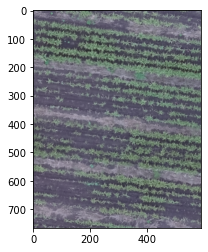

In [192]:
plt.imshow(img)

In [193]:
# Generación de espacio de color ExG 
g_2 = np.array(img[:,:,1], dtype = np.int32) *2 # Transformación de valores hacia np.int32 y multiplicación del verde x 2 
ExG = g_2 - np.array(img[:,:,0], dtype = np.int32) - np.array(img[:,:,2], dtype = np.int32) # Resta de canal rojo y azul
ExG[ExG < 0] = 0 # Supresión de todos los valores negativos

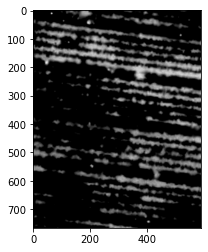

In [199]:
plt.imshow(ExG, cmap = "gray")

In [200]:
ExG_flip = ExG[:, ::-1]

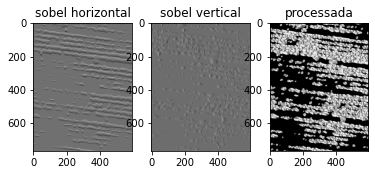

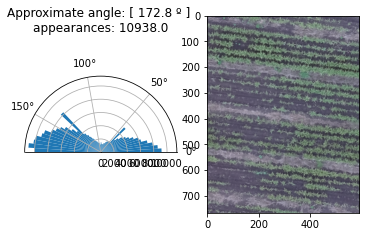

In [211]:
#variaveis
sample = 50 #quantidade de amostra no histograma, (melhor resultado quando proximo de 50)
#a imagem a ser analisada

gray = ExG/255 

#Aplicación de filtros de sobel
imgH = sobel_h(gray)
imgV = sobel_v(gray)
plt.subplot(131)
plt.title("sobel horizontal")
plt.imshow(imgH, cmap='gray')
plt.subplot(132)
plt.title("sobel vertical")
plt.imshow(imgV, cmap='gray')

mean_convolution = np.array([
    [1/9,1/9,1/9],
    [1/9,1/9,1/9],
    [1/9,1/9,1/9]
])

imgH = ndimage.convolve(imgH, mean_convolution)
imgV = ndimage.convolve(imgV, mean_convolution)

# imgA tendrá dos gradientes diferentes sobel_h y sobel_v

imgA = np.zeros(imgH.shape)
imgA = imgA + 2
# for i in range(imgH.shape[0]):
#     for j in range(imgH.shape[1]):
#         try: #try evita problemas cuando se accesan posiciones no existentes en el arreglo
#             #pega os 8 pexel ao redor para melhor distribuição diferencias. calculo da media entre eles
#             HtoMean = (imgH[i-1,j-1], imgH[i-1,j], imgH[i-1,j+1], imgH[i,j-1],
#              imgH[i,j+1], imgH[i+1,j-1], imgH[i+1,j], imgH[i+1,j+1], imgH[i,j]*2, 0)

#             VtoMean = (imgV[i-1,j-1], imgV[i-1,j], imgV[i-1,j+1], imgV[i,j-1],
#              imgV[i,j+1], imgV[i+1,j-1], imgV[i+1,j], imgV[i+1,j+1], imgV[i,j]*2, 0)
#             HtoMean = np.mean(HtoMean)
#             VtoMean = np.mean(VtoMean)
#             if VtoMean != 0: # Para evitar divisiones por zero
#                 imgA[i,j] = ((np.arctan(HtoMean/VtoMean))*2)/np.pi
#         except IndexError as e:
#             pass # se continue el loop si la posición no es existente

# imgV = gaussian(imgV, sigma = 2.5)
# imgH = gaussian(imgH, sigma = 2.5)


for i in range(imgH.shape[0]):
    for j in range(imgH.shape[1]):
        if imgV[i,j] != 0:
            
            imgA[i,j] = (((np.arctan(imgH[i,j]/imgV[i,j]))*2)/np.pi)
            
         
            
imgA = ((imgA*(-1) + 1)/2)*np.pi #ajuste de (-1 á 1) para (0 á pi) para calcular angulo
plt.subplot(133)
plt.title("processada")
plt.imshow(imgA, cmap='gray')
plt.show()


imgAd = imgA.ravel() #transformar matriz a un vector lineal

# imgAd_abs = imgAd

fig = plt.figure()
ax = fig.add_subplot(121, polar=True)

ax.set_thetamin(0)
ax.set_thetamax(180)
# imgAd_abs = np.abs(imgAd_abs)

# imgAd = imgAd[np.round(np.abs(imgAd *(180/np.pi)),2) != 90.00]

# imgAd[imgAd <= 0] += np.pi

# from scipy import stats

# print(stats.mode(imgAd *(180/np.pi)))

# mean_pi = np.mean(imgAd *(180/np.pi))

# mean_abs = np.mean(imgAd_abs*(180/np.pi))

# mean_final = (mean_pi+mean_abs)/2

# print(mean_pi)

# plt.hist(imgAd *(180/np.pi), sample)

# plt.show()

a,_,_ = plt.hist(imgAd, bins = sample,range=(0,np.pi)) # histograma de vector de ángulos, con 50 muestras en el intervalo de 0 a pi
plt.title("Approximate angle: [ " + str(round((np.argmax(a)/sample)*180,1)) + " º ] \nappearances: "+str(a.max()))
# (np.argmax(a)/sample)*180 obtiene la posición (entre las muestras) del ángulo con mayor frequencia y convierte para angulos de 0 a 180 º
ax = fig.add_subplot(122, polar=False)
plt.imshow(img)

plt.show()


In [9]:

otsu_threshold, image_result = cv2.threshold( np.array(ExG, dtype = np.uint8), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print("Obtained threshold: ", otsu_threshold)

Obtained threshold:  18.0


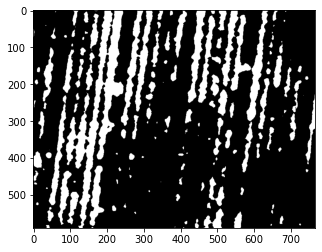

In [10]:
plt.imshow(image_result, cmap = 'gray')